# Initialization

## Imports

In [ ]:
import pandas as pd
import io
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.functional as F

## Data Loading

In [ ]:
SPLITS = {'train': 'data/train.parquet', 'validation': 'data/validation.parquet', 'test': 'data/test.parquet'}

train_df = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + SPLITS["train"])
valid_df = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + SPLITS["validation"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Global Values

In [ ]:
H_dash = 64
W_dash = 512

In [ ]:
CHARSET = "_abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 @#$%&*()-+=<,>.?"

In [ ]:
SEQUENCE_LENGTH = 50

In [ ]:
INPUT_DIM = 128

In [ ]:
CONV_CHANNELS = [4, 8]

In [ ]:
KERNEL_SIZE = 3
MAXPOOL_SIZE = 2

## Utils

In [ ]:
def display(image_to_show):
    plt.imshow(image_to_show.squeeze(), cmap = "gray")
    plt.axis("off")
    plt.show()

In [ ]:
def combine(images):
    multiline_image = torch.stack(list(images))
    multiline_image = multiline_image.view(1, -1, W_dash)
    return multiline_image

In [ ]:
def char2idx(charset, char):
    return charset.index(char)

In [ ]:
class TextObject:
    def __init__(self, charset = CHARSET, seq_length = SEQUENCE_LENGTH):
        self.charset = charset
        self.seq_length = seq_length

    def char2idx(self, char):
        return char2idx(self.charset, char)

    def __call__(self, text):
        s = []
        for i in range(self.seq_length):
            t = [0] * len(self.charset)
            if i < len(text):
                # t = [0] * (len(self.charset) + 1)
                c = text[i]
                if c not in self.charset:
                    c = "?"
                t[self.char2idx(c)] = 1
                s.append(t)
            else:
                t[0] = 1
                s.append(t)

        s = torch.tensor(s)
        return s

In [ ]:
text_preprocessor = T.Compose([
    TextObject()
])

In [ ]:
def idx2char(i):
    return CHARSET[i]

In [ ]:
def textify(bld):
    B, L, D = bld.shape
    texts = []
    for ld in bld:
        text = ""
        for d in ld:
            text += idx2char(torch.argmax(d))
        texts.append(text)
    return texts

## HTR Segmentation

In [ ]:
def get_ht(multiline_image):
    ht = []
    for i in range(0, multiline_image.shape[1], H_dash):
        ht.append(multiline_image[0, i : i + H_dash, :].unsqueeze(0))

    return torch.cat(ht, dim = 0).view(len(ht), 1, H_dash, -1)

## Preprocessing

In [ ]:
class ImageObject:
    def __call__(self, image_dict):
        image_bytes = image_dict["bytes"]
        return Image.open(io.BytesIO(image_bytes))

In [ ]:
image_preprocessor = T.Compose([
    ImageObject(),
    T.Grayscale(), # Channels: 3 -> 1
    T.ToTensor(),
    T.Lambda(lambda x: (x > 0.5).float()), # Binarizes the image
    T.Resize((64, 512)) # Random values for width and height
])

In [ ]:
train_df["image"] = train_df["image"].apply(image_preprocessor)
valid_df["image"] = valid_df["image"].apply(image_preprocessor)

In [ ]:
train_df["label"] = train_df["text"].apply(text_preprocessor)
valid_df["label"] = valid_df["text"].apply(text_preprocessor)

In [ ]:
# Set aside some images for the demo
test_df = valid_df.tail(10).reset_index(drop = True)

## Feature Extractor (CNN)

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, num_classes = len(CHARSET)):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, CONV_CHANNELS[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(CONV_CHANNELS[0], CONV_CHANNELS[1], kernel_size = KERNEL_SIZE, padding=1)
        self.pool = nn.MaxPool2d(MAXPOOL_SIZE, MAXPOOL_SIZE)
        self.fc1 = nn.Linear(CONV_CHANNELS[1] * 16 * 128, INPUT_DIM)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, CONV_CHANNELS[1] * 16 * 128)
        x = F.relu(self.fc1(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim = INPUT_DIM, num_classes = len(CHARSET), seq_len = SEQUENCE_LENGTH):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes * seq_len)
        self.seq_len = seq_len
        self.num_classes = num_classes

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.seq_len, self.num_classes)
        return x

In [ ]:
class Model(nn.Module):
    def __init__(self, num_chars, seq_len):
        super(Model, self).__init__()
        self.cnn = CNNEncoder() # CNN based feature extractor
        self.decoder = Decoder() # Fully connected neural network decoder
        self.activation = nn.Softmax(dim = 2) # Softmax final activation function

    def forward(self, images):
        cnn_features = self.cnn(images)
        output = self.decoder(cnn_features)
        output = self.activation(output)
        return output

## Loss

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, labels, outputs):
        if outputs.shape != labels.shape:
            raise ValueError("Outputs and labels tensors must have the same shape.")

        # Compute cross entropy for each row of each matrix (L, C)
        B, L, C = outputs.shape
        criterion = nn.CrossEntropyLoss(reduction='none')
        labels = labels.to(torch.float32)
        loss = 0

        for i in range(B):
            loss += criterion(labels[i], outputs[i]).sum()

        return loss / B


## Training

In [ ]:
num_characters = len(CHARSET)  # Adjust based on your character set
sequence_length = SEQUENCE_LENGTH  # Max length of your text sequence
model = Model(num_characters, sequence_length)  # Model

criterion = CustomLoss()  # Loss

optimizer = optim.Adam(model.parameters(), lr = 0.001)  # Optimizer

# Training loop
num_epochs = 5  # Adjust as needed
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(train_df), batch_size):
        batch = train_df[i : i + batch_size]
        images = torch.stack(batch["image"].tolist())
        labels = torch.stack(batch["label"].tolist())
        B, C, H, W = images.shape
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(labels, outputs)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, len(valid_df), batch_size):
            batch = valid_df[i : i + batch_size]
            images = torch.stack(batch["image"].tolist())
            labels = torch.stack(batch["label"].tolist())
            B, C, H, W = images.shape
            outputs = model(images)

            loss = criterion(labels, outputs)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss / len(valid_df):.4f}")

Epoch 1/5, Training Loss: 212.0388, Validation Loss: 6.6666
Epoch 2/5, Training Loss: 212.0388, Validation Loss: 6.6666
Epoch 3/5, Training Loss: 212.0388, Validation Loss: 6.6666
Epoch 4/5, Training Loss: 212.0388, Validation Loss: 6.6666
Epoch 5/5, Training Loss: 212.0388, Validation Loss: 6.6666


# Demo

## Sample Image

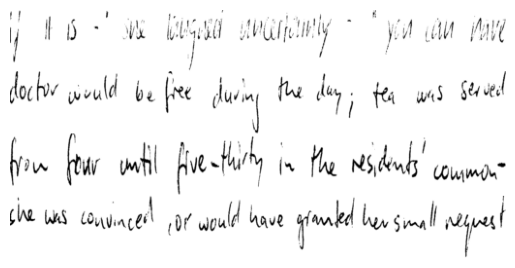

In [ ]:
sample_image = combine(test_df.iloc[: 4, 1])
display(sample_image)

## Segmentation

In [ ]:
images = get_ht(sample_image)

In [ ]:
images.shape

torch.Size([4, 1, 64, 512])

## Preprocessing

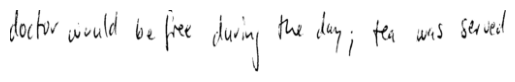

In [ ]:
# images = image_preprocessor(images)
display(images[1])

## Prediction (Logits)

In [ ]:
prediction = model(images)
prediction.shape

torch.Size([4, 50, 80])

## Prediction (Text)

In [ ]:
text_prediction = textify(prediction)
text_prediction

['to t r e   et   _ eh  e       o te o_ __ ____oe___',
 'to t r e   et   _ eh  e       o te o_ __ ____oe___',
 'to t r e   et   _ eh  e       o te o_ __ ____oe___',
 'to t r e   et   _ eh  e       o te o_ __ ____oe___']